In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

years = range(2015, 2026)
era5_files = [f"../data/raw/era5_tmax_daily_{year}.nc" for year in years]

ds_era5_list = []
for file in era5_files:
    ds = xr.open_dataset(file)
    if not np.issubdtype(ds.valid_time.dtype, np.datetime64):
        ds['valid_time'] = pd.to_datetime(ds.valid_time.values)
    ds_era5_list.append(ds)

ds_era5 = xr.concat(ds_era5_list, dim='valid_time')

station_data_list = []
coords_list = []

for year in years:
    temp_file = f"../data/processed/tmax_diaria_por_estacion_5_45_-95_-65_{year}.csv"
    df_temp = pd.read_csv(temp_file, index_col=0, parse_dates=True)
    station_data_list.append(df_temp)
    
    coords_file = f"../data/processed/coordenadas_estaciones_5_45_-95_-65_{year}.csv"
    df_coords = pd.read_csv(coords_file, index_col=0)
    coords_list.append(df_coords)

df_pivot = pd.concat(station_data_list, axis=0)
coords_df = pd.concat(coords_list, axis=0).drop_duplicates()

df_pivot.columns = df_pivot.columns.astype(float)
coords_df.index = coords_df.index.astype(float)

common_ids = df_pivot.columns.intersection(coords_df.index)
df_pivot = df_pivot[common_ids]
coords_df = coords_df.loc[common_ids]

print(f"\nFinal dataset:")
print(f"Number of stations: {len(common_ids)}")
print(f"Date range: {df_pivot.index.min()} to {df_pivot.index.max()}")

station_coords = coords_df[['lat', 'lon']].to_dict(orient='index')



Final dataset:
Number of stations: 311
Date range: 2015-01-01 00:00:00 to 2025-08-01 00:00:00


In [2]:
records = []

for station_id in df_pivot.columns:
    obs_series = df_pivot[station_id]
    
    if obs_series.isna().all():
        continue

    if station_id not in coords_df.index:
        continue

    lat_est = coords_df.loc[station_id, 'lat']
    lon_est = coords_df.loc[station_id, 'lon']

    ds_point = ds_era5.sel(latitude=lat_est, longitude=lon_est, method='nearest')
    era5_series = (ds_point['t2m'] - 273.15).to_series()
    era5_series.index = ds_point.valid_time.values
    
    common_dates = obs_series.index.intersection(era5_series.index)
    
    obs_series = obs_series[common_dates]
    era5_series = era5_series[common_dates]
    
    valid_data = obs_series.notna()
    obs_series = obs_series[valid_data]
    era5_series = era5_series[valid_data]
    
    if len(obs_series) > 0:
        df_cmp = pd.DataFrame({
            'date': obs_series.index,
            'station_id': station_id,
            'obs': obs_series.values,
            'era5': era5_series.values
        })
        records.append(df_cmp)


In [3]:
df_all = pd.concat(records, ignore_index=True)
print("\nComparison dataset:")
print(f"Total number of records: {len(df_all)}")
print(f"Number of stations: {df_all['station_id'].nunique()}")
print(f"Date range: {df_all['date'].min()} to {df_all['date'].max()}")
print("\nSummary statistics:")
print(df_all[['obs', 'era5']].describe())

# Calculate overall correlation and bias
correlation = df_all['obs'].corr(df_all['era5'])
bias = (df_all['obs'] - df_all['era5']).mean()
rmse = np.sqrt(((df_all['obs'] - df_all['era5'])**2).mean())



print("\nOverall statistics:")
print(f"Correlation: {correlation:.3f}")
print(f"Mean bias (obs - ERA5): {bias:.3f}°C")
print(f"RMSE: {rmse:.3f}°C")



Comparison dataset:
Total number of records: 677882
Number of stations: 298
Date range: 2015-01-01 00:00:00 to 2025-07-09 00:00:00

Summary statistics:
                 obs           era5
count  677882.000000  677882.000000
mean       22.266118      21.306232
std        11.812313      10.637008
min       -38.400000     -29.334808
25%        15.000000      14.434723
50%        26.400000      25.298492
75%        31.400000      29.157379
max        90.000000      44.255035

Overall statistics:
Correlation: 0.926
Mean bias (obs - ERA5): 0.960°C
RMSE: 4.566°C


In [4]:
correlations = []

for station_id in df_pivot.columns:
    obs_series = df_pivot[station_id]
    if obs_series.isna().all():
        correlations.append(np.nan)
        continue

    if station_id not in coords_df.index:
        correlations.append(np.nan)
        continue

    lat_est = coords_df.loc[station_id, 'lat']
    lon_est = coords_df.loc[station_id, 'lon']

    ds_point = ds_era5.sel(latitude=lat_est, longitude=lon_est, method='nearest')
    era5_series = (ds_point['t2m'] - 273.15).to_series()

    df_cmp = pd.DataFrame({
        'obs': obs_series,
        'era5': era5_series
    }).dropna()

    if len(df_cmp) < 2:
        correlations.append(np.nan)
    else:
        corr, _ = pearsonr(df_cmp['obs'], df_cmp['era5'])
        correlations.append(corr)

coords_df['correlation'] = correlations


In [5]:
area = [45, -95, 5, -65]
lat_max, lon_min, lat_min, lon_max = area


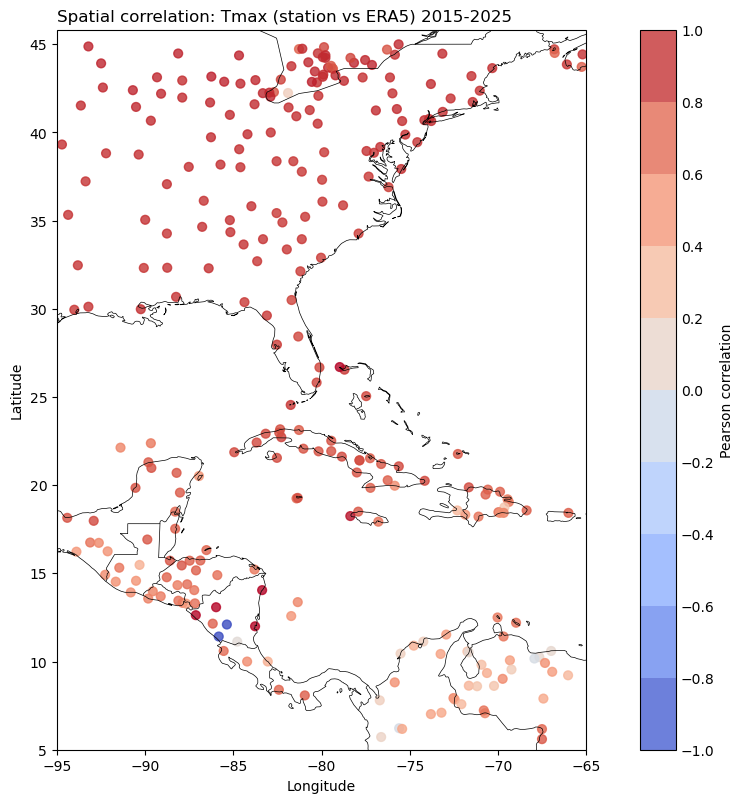

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

bounds = np.linspace(-1, 1, 11)  
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cmap = plt.colormaps['RdBu_r']

fig = plt.figure(figsize=(12, 8))
ax = plt.axes([0.05, 0.05, 0.9, 0.9], projection=ccrs.PlateCarree())

coords_plot = coords_df.dropna(subset=['lat', 'lon', 'correlation'])

sc = ax.scatter(
    coords_plot['lon'], coords_plot['lat'],
    s=40,
    c=coords_plot['correlation'],
    cmap='coolwarm',
    vmin=-1, vmax=1,
    alpha=0.8,
    marker='o',
    edgecolors=None,
    transform=ccrs.PlateCarree()
)

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

ax.set_xticks(np.arange(lon_min, lon_max + 1, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

cb = plt.colorbar(sc, ax=ax, boundaries=bounds, ticks=bounds, label='Pearson correlation')
cb.ax.tick_params(length=0)  

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Spatial correlation: Tmax (station vs ERA5) 2015-2025', loc='left')
plt.show()


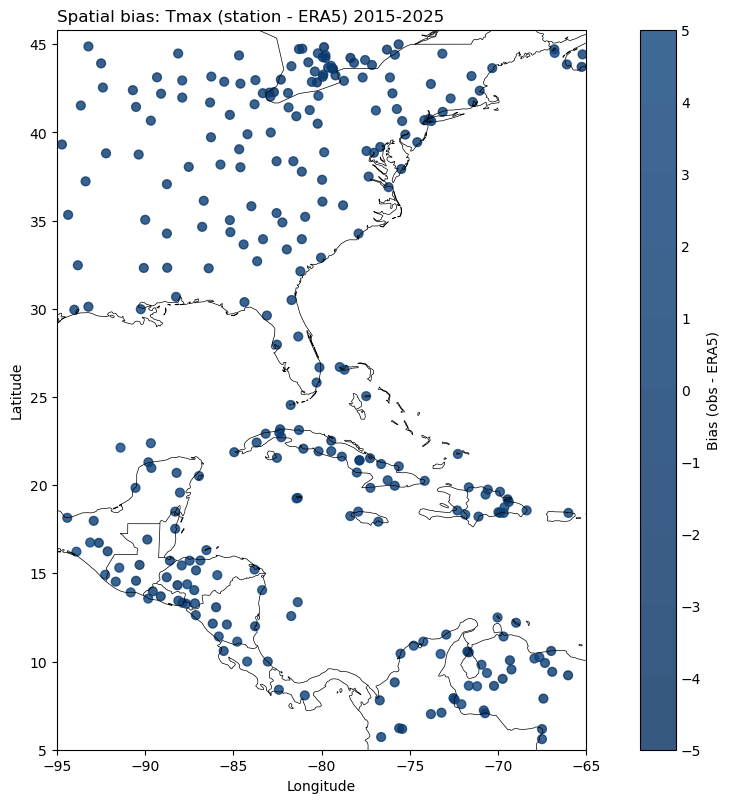

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

biases = []

for station_id in df_pivot.columns:
    obs_series = df_pivot[station_id]
    if obs_series.isna().all():
        biases.append(np.nan)
        continue

    if station_id not in coords_df.index:
        biases.append(np.nan)
        continue

    lat = coords_df.loc[station_id, 'lat']
    lon = coords_df.loc[station_id, 'lon']

    ds_point = ds_era5.sel(latitude=lat, longitude=lon, method='nearest')
    era5_series = (ds_point['t2m'] - 273.15).to_series()

    df_cmp = pd.DataFrame({'obs': obs_series, 'era5': era5_series}).dropna()

    if len(df_cmp) < 2:
        biases.append(np.nan)
    else:
        bias = (df_cmp['obs'] - df_cmp['era5']).mean()
        biases.append(bias)

coords_df['bias'] = biases

bounds = np.linspace(-5, 5, 11)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cmap = plt.colormaps['RdBu_r']

fig = plt.figure(figsize=(12, 8))
ax = plt.axes([0.05, 0.05, 0.9, 0.9], projection=ccrs.PlateCarree())

coords_plot = coords_df.dropna(subset=['lat', 'lon', 'bias'])

sc = ax.scatter(
    coords_plot['lon'], coords_plot['lat'],
    s=40,
    c=coords_plot['bias'],
    cmap=cmap,
    norm=norm,
    alpha=0.8,
    marker='o',
    edgecolors=None,
    transform=ccrs.PlateCarree()
)

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.set_xticks(np.arange(lon_min, lon_max + 1, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

cb = plt.colorbar(sc, ax=ax, boundaries=bounds, ticks=bounds, label='Bias (obs - ERA5)')
cb.ax.tick_params(length=0)

ax.set_title('Spatial bias: Tmax (station - ERA5) 2015-2025', loc='left')
plt.show()


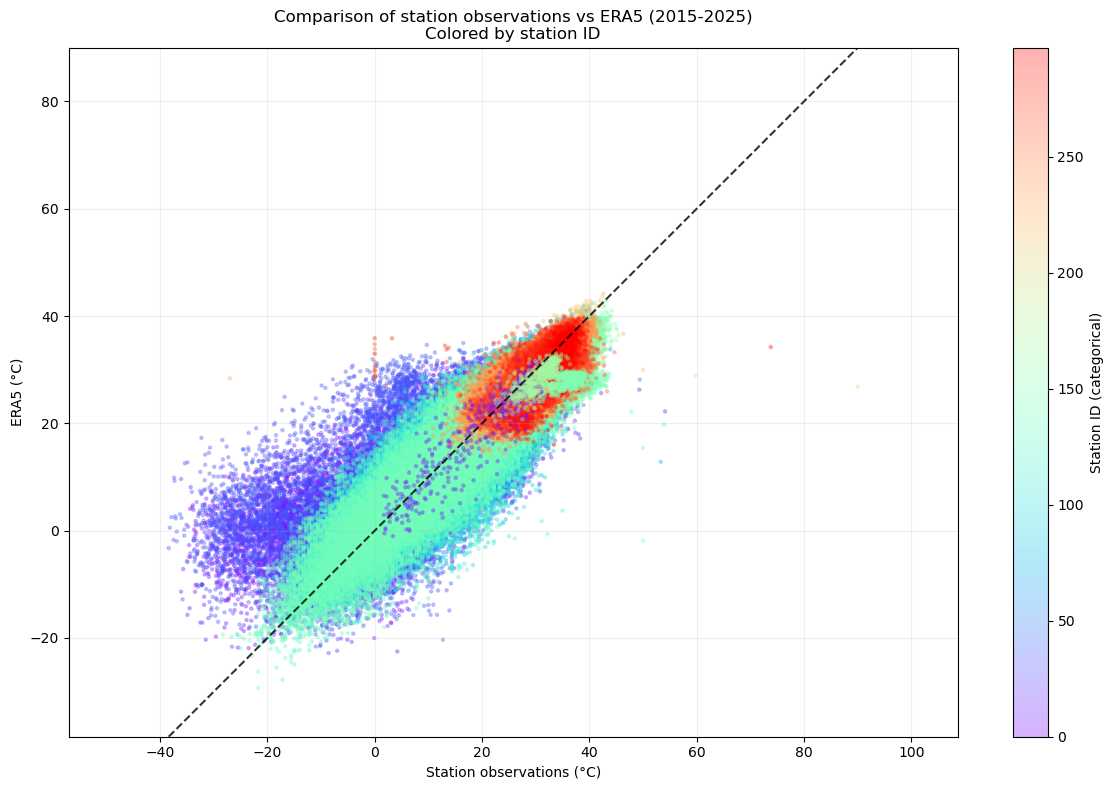

In [10]:
# Create figure
plt.figure(figsize=(12, 8))

# Create scatter plot with colors by station
scatter = plt.scatter(df_all['obs'], df_all['era5'], 
                     c=df_all['station_id'].astype('category').cat.codes,  # Convert station IDs to categorical codes
                     cmap='rainbow',  # Use rainbow colormap for better distinction between stations
                     alpha=0.3,
                     s=5)  # Small point size for better visibility

# Add 1:1 line
plt.plot([df_all[['obs', 'era5']].min().min(), df_all[['obs', 'era5']].max().max()], 
         [df_all[['obs', 'era5']].min().min(), df_all[['obs', 'era5']].max().max()], 
         'k--', alpha=0.8, label='1:1 line')

plt.xlabel('Station observations (°C)')
plt.ylabel('ERA5 (°C)')
plt.title('Comparison of station observations vs ERA5 (2015-2025)\nColored by station ID')

# Add grid for better readability
plt.grid(True, alpha=0.2)

# Make plot square and adjust limits
plt.axis('equal')
plt.xlim(df_all[['obs', 'era5']].min().min(), df_all[['obs', 'era5']].max().max())
plt.ylim(df_all[['obs', 'era5']].min().min(), df_all[['obs', 'era5']].max().max())

# Add colorbar
plt.colorbar(scatter, label='Station ID (categorical)')

# Adjust layout
plt.tight_layout()


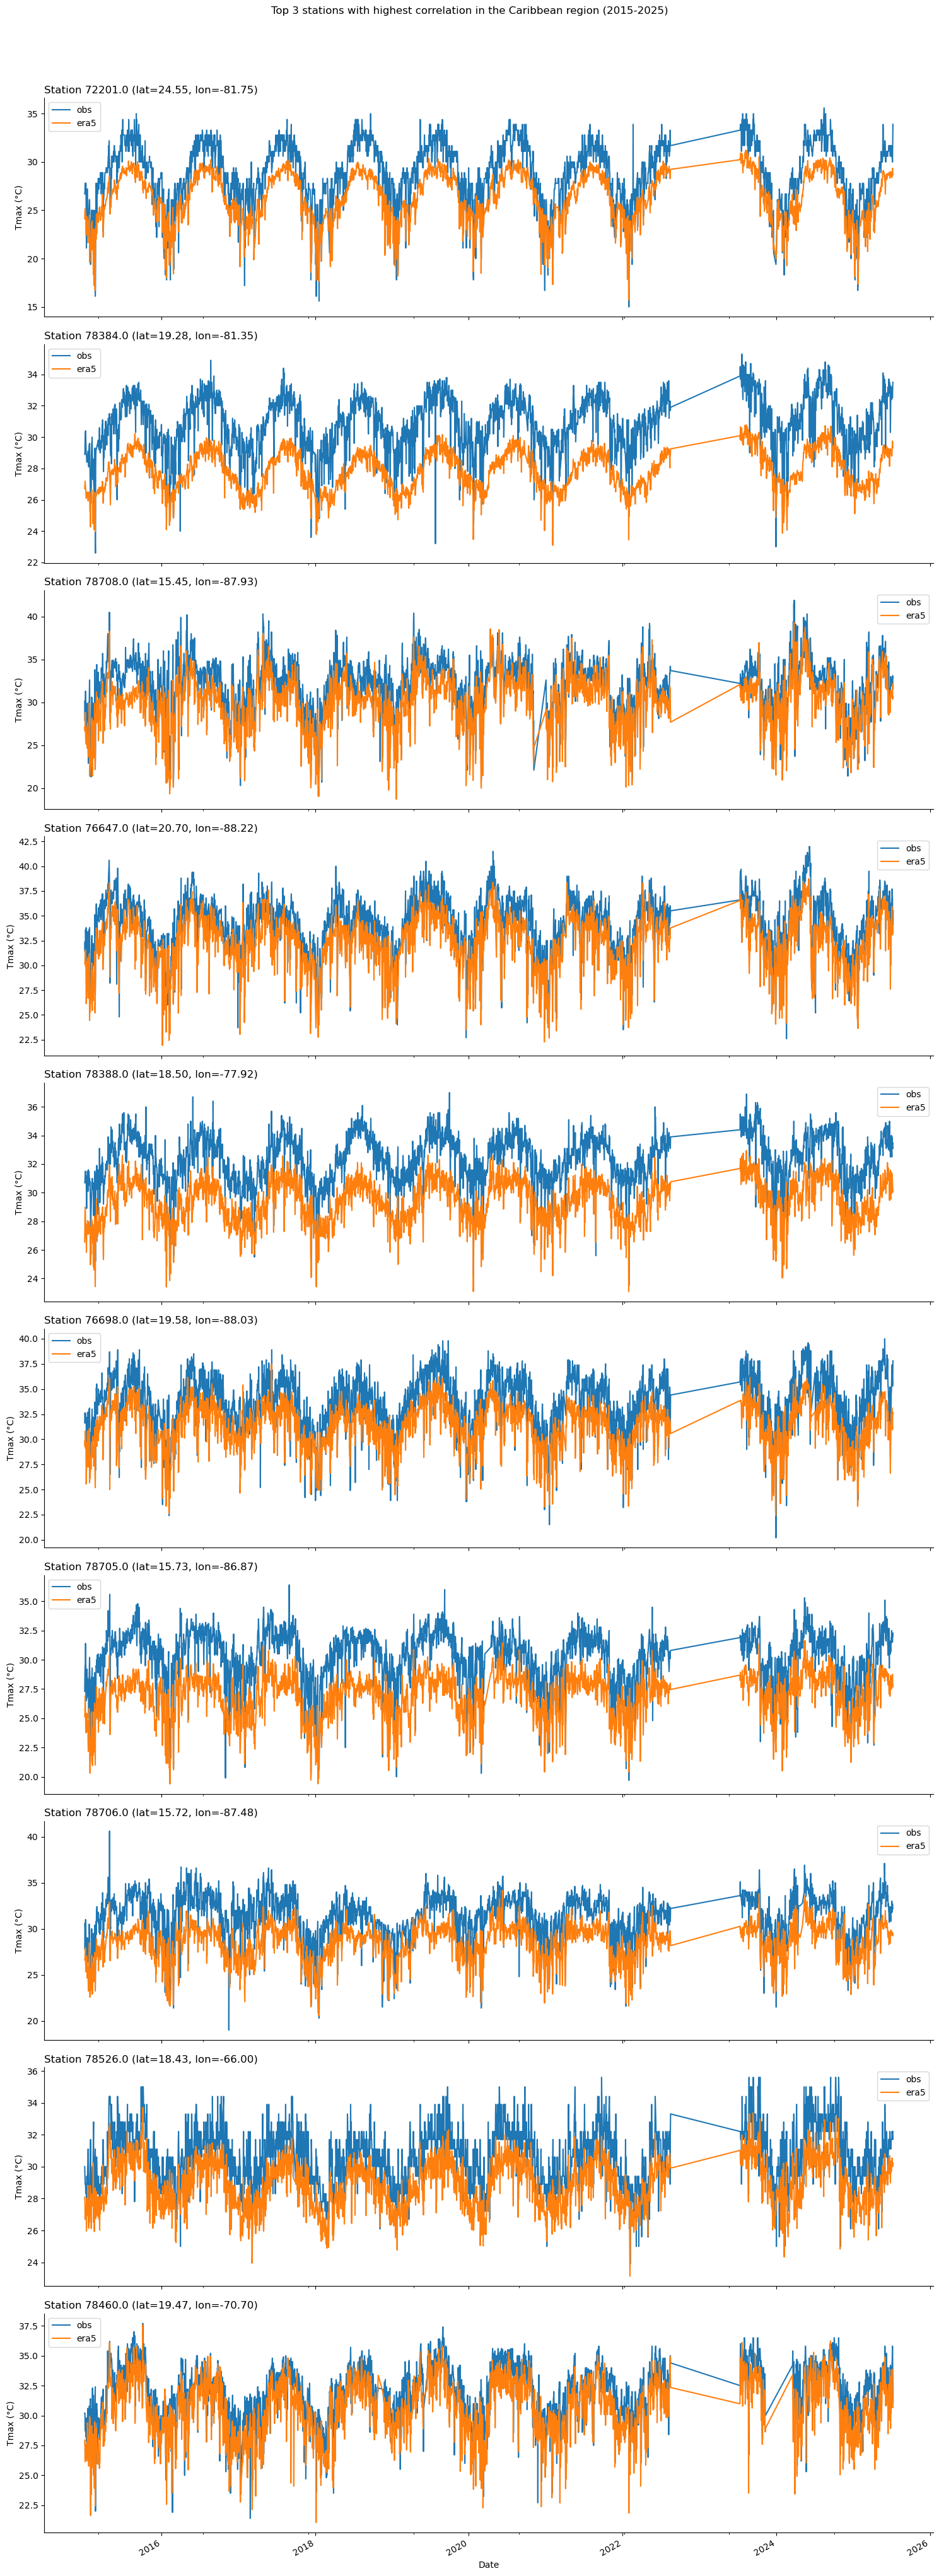

In [14]:
caribbean_df = coords_df[
    (coords_df['lat'] >= 10) & (coords_df['lat'] <= 25) &
    (coords_df['lon'] >= -90) & (coords_df['lon'] <= -60)
]

obs_counts = df_pivot.count()
caribbean_df = caribbean_df.join(obs_counts.rename("n_obs"))
caribbean_df = caribbean_df.dropna(subset=['correlation'])
caribbean_df = caribbean_df[caribbean_df['n_obs'] >= 3000]

top_caribbean = caribbean_df.sort_values(by='correlation', ascending=False).head(10)
top_station_ids = top_caribbean.index.tolist()

fig, axes = plt.subplots(len(top_station_ids), 1, figsize=(15, 4 * len(top_station_ids)), sharex=True)

for ax, station_id in zip(axes, top_station_ids):
    lat = coords_df.loc[station_id, 'lat']
    lon = coords_df.loc[station_id, 'lon']
    obs_series = df_pivot[station_id]

    ds_point = ds_era5.sel(latitude=lat, longitude=lon, method='nearest')
    era5_series = (ds_point['t2m'] - 273.15).to_series()

    df_cmp = pd.DataFrame({
        'obs': obs_series,
        'era5': era5_series
    }).dropna()

    df_cmp.plot(ax=ax, ylabel="Tmax (°C)")
    ax.set_title(f"Station {station_id} (lat={lat:.2f}, lon={lon:.2f})", loc='left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.xlabel("Date")
plt.suptitle('Top 3 stations with highest correlation in the Caribbean region (2015-2025)', y=1.02)
plt.tight_layout()
plt.show()
